In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Wed Aug  9 07:22:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
df = pd.read_csv('/content/sample_data/cleaned_wine_df.csv')

In [ ]:
df.head(3)

,country,description,points,price,province,region_1,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,19.0,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013


In [ ]:
# 1. Preprocess the `description` column

# Check for missing values in the description and points columns
missing_values = df[['description', 'points']].isnull().sum()

# Drop rows with missing descriptions (if any)
df = df.dropna(subset=['description'])

# 2. Transform the `points` column into categorical labels

# Define bins for the wine ratings and labels for each bin
bins = [0, 85, 90, 100]
labels = ['low', 'medium', 'high']

# Create a new column 'rating_category' with the binned labels
df['rating_category'] = pd.cut(df['points'], bins=bins, labels=labels, include_lowest=True)

missing_values, df[['description', 'rating_category']].head()

(description    0
 points         0
 dtype: int64,
                                          description rating_category
 0  Aromas include tropical fruit, broom, brimston...          medium
 1  This is ripe and fruity, a wine that is smooth...          medium
 2  Tart and snappy, the flavors of lime flesh and...          medium
 3  Pineapple rind, lemon pith and orange blossom ...          medium
 4  Much like the regular bottling from 2012, this...          medium)

In [ ]:
df['rating_category'].value_counts()

medium    64461
high      31090
low       20051
Name: rating_category, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

# Assuming df is your dataframe
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['rating_category'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['rating_category'], random_state=42)

In [23]:
train_df.shape, valid_df.shape, test_df.shape

((92481, 11), (11560, 11), (11561, 11))

In [24]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the descriptions
train_encodings = tokenizer.batch_encode_plus(
    train_df['description'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='max_length',
    max_length=150,
    return_tensors='pt'
)

valid_encodings = tokenizer.batch_encode_plus(
    valid_df['description'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='max_length',
    max_length=150,
    return_tensors='pt'
)

test_encodings = tokenizer.batch_encode_plus(
    test_df['description'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='max_length',
    max_length=150,
    return_tensors='pt'
)


# Extract the input IDs, attention masks, and labels
train_labels = train_df['rating_category'].astype('category').cat.codes.values
valid_labels = valid_df['rating_category'].astype('category').cat.codes.values
test_labels = test_df['rating_category'].astype('category').cat.codes.values

In [25]:
import torch
from torch.utils.data import TensorDataset

# Convert data into torch tensors for training set
train_input_ids = train_encodings['input_ids'].clone().detach()
train_attention_masks = train_encodings['attention_mask'].clone().detach()
train_labels = torch.tensor(train_labels, dtype=torch.long)

# Convert data into torch tensors for validation set
valid_input_ids = valid_encodings['input_ids'].clone().detach()
valid_attention_masks = valid_encodings['attention_mask'].clone().detach()
valid_labels = torch.tensor(valid_labels, dtype=torch.long)

# Convert data into torch tensors for test set
test_input_ids = test_encodings['input_ids'].clone().detach()
test_attention_masks = test_encodings['attention_mask'].clone().detach()
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create tensor datasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create dataloaders

# Training dataloader
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

# Validation dataloader
validation_dataloader = DataLoader(
    valid_dataset,
    sampler=SequentialSampler(valid_dataset),
    batch_size=batch_size
)

# Test dataloader
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [27]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=10, shuffle=True, random_state=None)

In [28]:
!nvidia-smi

Wed Aug  9 08:13:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import os

# Define your path
save_path = "/content/drive/MyDrive/Colab Notebooks/models"

# Check if the directory exists, if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Directory {save_path} created!")
else:
    print(f"Directory {save_path} already exists!")


Directory /content/drive/MyDrive/Colab Notebooks/models already exists!


In [32]:
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import AdamW
import torch.nn as nn
import torch

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Training hyperparameters
epochs = 4
batch_size = 16
gradient_accumulation_steps = 1
max_grad_norm = 1.0

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up the data loaders using the previously defined datasets
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)

# Initialize the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(df['rating_category'].cat.categories),
    output_attentions=False,
    output_hidden_states=False,
    problem_type='single_label_classification',
    hidden_dropout_prob=0.5  # Adjust this value
)
model.to(device)

# Loss function and optimizer setup
loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Define the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

best_val_f1 = 0  # Track the best validation F1 score
path_to_save = "/content/drive/MyDrive/Colab Notebooks/models/best_model.bin"

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        loss = loss_function(outputs.logits, inputs['labels'])
        loss = loss / gradient_accumulation_steps  # Adjust the loss for gradient accumulation
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()  # Update the learning rate
            model.zero_grad()

            total_train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    predictions, true_vals = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(input_ids=batch[0], attention_mask=batch[1])

        logits = outputs[0].detach().cpu().numpy()
        label_ids = batch[2].cpu().numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_vals.extend(label_ids)

    # Calculate validation metrics
    val_accuracy = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions, average='weighted')
    print(f"Validation Accuracy: {val_accuracy:.4f} - F1 Score: {val_f1:.4f}")

    # Save the model if it's the best one seen so far
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), path_to_save)

# After training is done, evaluate the model on the test dataset
model.eval()
predictions, true_vals = [], []

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(input_ids=batch[0], attention_mask=batch[1])

    logits = outputs[0].detach().cpu().numpy()
    label_ids = batch[2].cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))
    true_vals.extend(label_ids)

# Calculate test metrics
test_accuracy = accuracy_score(true_vals, predictions)
test_f1 = f1_score(true_vals, predictions, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f} - F1 Score: {test_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 - Training Loss: 0.6677
Validation Accuracy: 0.7560 - F1 Score: 0.7528
Epoch 2/4 - Training Loss: 0.5790
Validation Accuracy: 0.7631 - F1 Score: 0.7630
Epoch 3/4 - Training Loss: 0.5455
Validation Accuracy: 0.7625 - F1 Score: 0.7632
Epoch 4/4 - Training Loss: 0.5251
Validation Accuracy: 0.7676 - F1 Score: 0.7669
Test Accuracy: 0.7656 - F1 Score: 0.7650


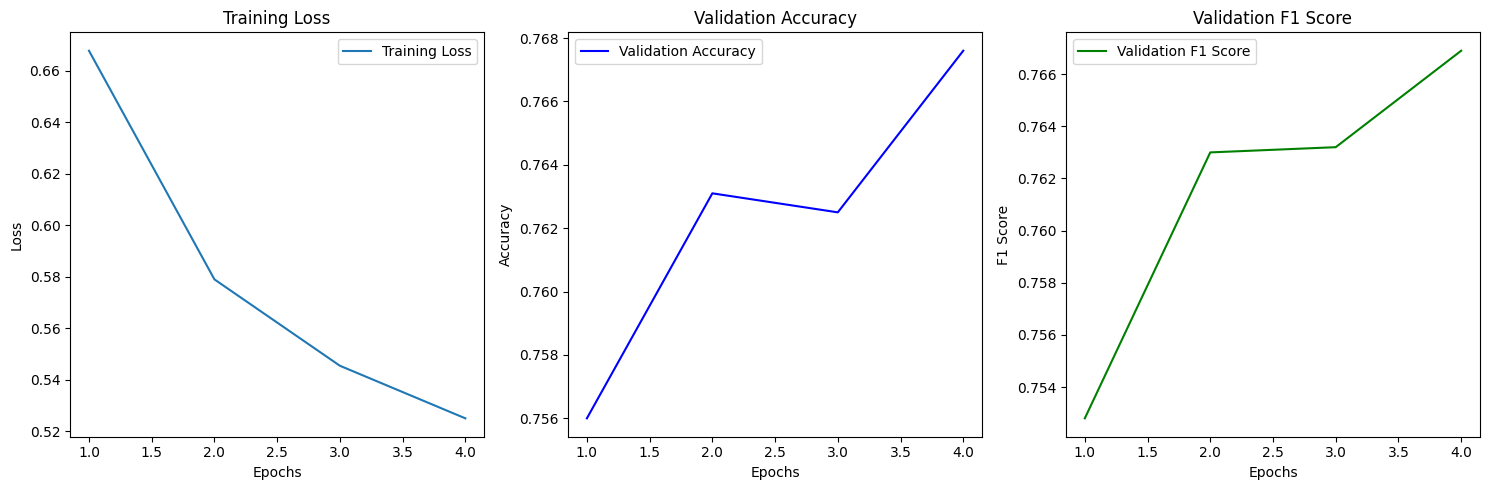

In [34]:
import matplotlib.pyplot as plt

# Sample data (replace these lists with your actual data)
epochs_range = list(range(1, epochs + 1))
training_losses = [0.6677, 0.5790, 0.5455, 0.5251]
validation_accuracies = [0.7560, 0.7631, 0.7625, 0.7676]
validation_f1_scores = [0.7528, 0.7630, 0.7632, 0.7669]

# Plotting training loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Plotting validation F1 score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, validation_f1_scores, label='Validation F1 Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()